# Customer Segmentation notebook
- This will run the full pipeline: preparation, scaling, K-Means (optimal k via silhouette), visualizations
- cluster analysis (average spending per cluster), and a DBSCAN comparison.
- The plots will appear inline and key tables will be displayed as tables.

# Libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# 1. Load Dataset

In [21]:

# Load dataset
df = pd.read_csv("Mall_Customers.csv")

# Inspect
print(df.head())
print(df.info())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


# 2. Select Features (Annual Income & Spending Score)


In [22]:
features = ["Annual Income (k$)", "Spending Score (1-100)"]
X = df[features].values

# 3. Visual Exploration


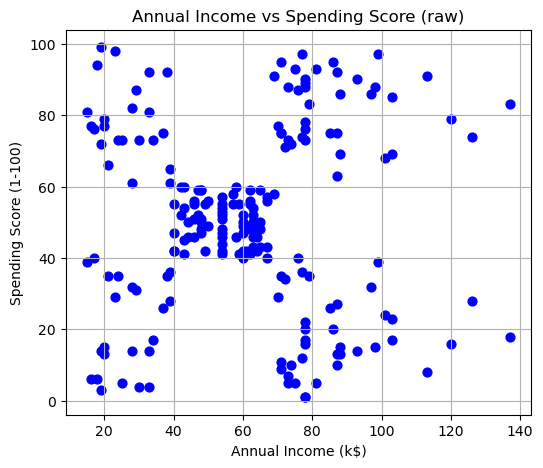

In [23]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=40, c='blue')
plt.title("Annual Income vs Spending Score (raw)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(True)
plt.show()

# 4. Feature Scaling


In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Elbow Method + Silhouette Score


In [25]:
inertias = []
sil_scores = []
ks = range(2,11)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow


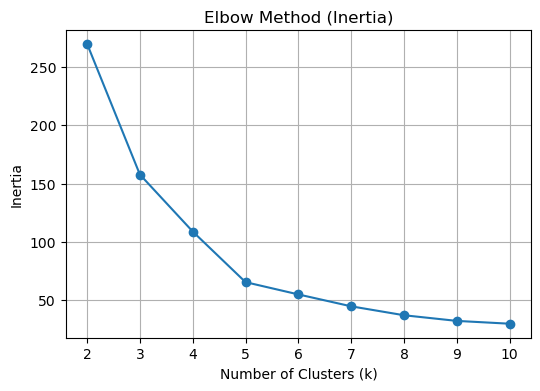

In [26]:
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# Plot Silhouette


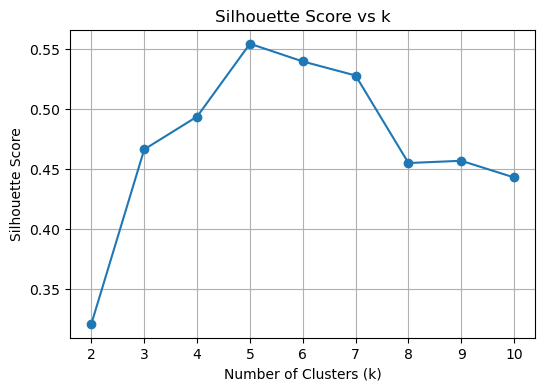

In [27]:
plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Score vs k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Choose best k


In [28]:
best_k = ks[np.argmax(sil_scores)]
print(f"Best number of clusters (by silhouette score): {best_k}")

Best number of clusters (by silhouette score): 5


# 6. Final KMeans


In [29]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
k_labels = kmeans.fit_predict(X_scaled)
df["Cluster_KMeans"] = k_labels

In [30]:
# Centroids (back to original scale)
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

# 7. Visualize KMeans Clusters


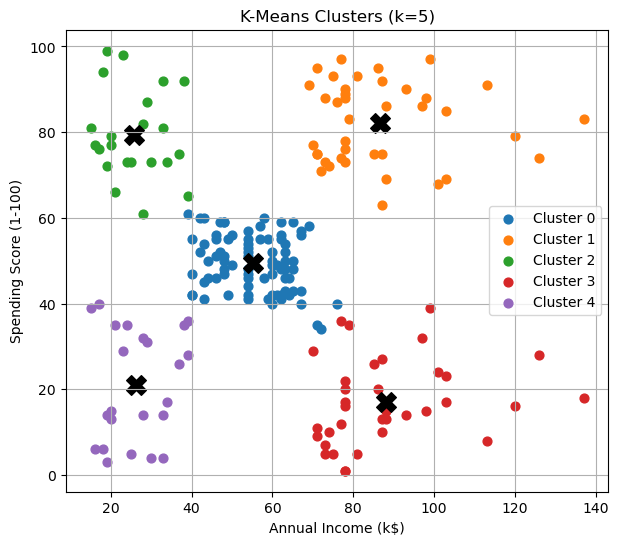

In [31]:
plt.figure(figsize=(7,6))
for cl in np.unique(k_labels):
    mask = df["Cluster_KMeans"] == cl
    plt.scatter(df.loc[mask, "Annual Income (k$)"],
                df.loc[mask, "Spending Score (1-100)"],
                s=40, label=f'Cluster {cl}')
plt.scatter(centroids[:,0], centroids[:,1], marker='X', s=200, c='black')
plt.title(f"K-Means Clusters (k={best_k})")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.grid(True)
plt.show()

# 8. Cluster Analysis (average income & spending per cluster)


In [32]:
cluster_summary = df.groupby("Cluster_KMeans")[["Annual Income (k$)", "Spending Score (1-100)"]].mean()
cluster_summary["Count"] = df["Cluster_KMeans"].value_counts().sort_index()
print("\nCluster Summary (KMeans):\n", cluster_summary)


Cluster Summary (KMeans):
                 Annual Income (k$)  Spending Score (1-100)  Count
Cluster_KMeans                                                   
0                        55.296296               49.518519     81
1                        86.538462               82.128205     39
2                        25.727273               79.363636     22
3                        88.200000               17.114286     35
4                        26.304348               20.913043     23


# 9. Average Spending per Cluster


In [33]:
avg_spending = df.groupby("Cluster_KMeans")["Spending Score (1-100)"].mean()
print("\nAverage Spending per Cluster:\n", avg_spending)


Average Spending per Cluster:
 Cluster_KMeans
0    49.518519
1    82.128205
2    79.363636
3    17.114286
4    20.913043
Name: Spending Score (1-100), dtype: float64


# 10. Bonus: DBSCAN



DBSCAN found 2 clusters (label -1 = noise)


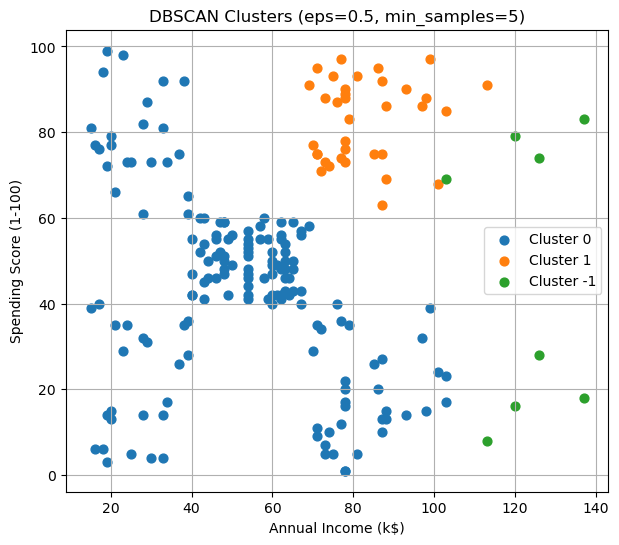

In [34]:
db = DBSCAN(eps=0.5, min_samples=5)
db_labels = db.fit_predict(X_scaled)
df["Cluster_DBSCAN"] = db_labels

n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"\nDBSCAN found {n_clusters_db} clusters (label -1 = noise)")

plt.figure(figsize=(7,6))
for lab in set(db_labels):
    mask = df["Cluster_DBSCAN"] == lab
    plt.scatter(df.loc[mask, "Annual Income (k$)"],
                df.loc[mask, "Spending Score (1-100)"],
                s=40, label=f'Cluster {lab}')
plt.title("DBSCAN Clusters (eps=0.5, min_samples=5)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.grid(True)
plt.show()


# 11. Save Dataset with Clusters


In [35]:
df.to_csv("customer_segments_with_clusters.csv", index=False)
print("\nClustered dataset saved as 'customer_segments_with_clusters.csv'")



Clustered dataset saved as 'customer_segments_with_clusters.csv'
